# 2CSSID-Workshop04. Règles d'association

Dans ce workshop, nous alons implémenter les règles d'association avec la fonction A-Priori.
Ensuite, nous allons comparer entre les méthodes de génération des itemsets: A-priori, FPmax and FPgrowth.
Aussi, nous allons tester l'effet des hyper-paramètres comme la confiance et le lift.

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.24.3', '2.0.3', '3.7.2')

In [2]:
from typing import Tuple, List, Type, Dict

## I. Réalisation des algorithmes

Dans cette partie, nous allons implémenter les règles d'association avec la fonction A-Priori. 
Chaque transaction (ligne) est représentée par un vecteur de taille $|I|$ où $I$ est la liste des items. 
Lorsqu'il y a un $1$, le item est vu dans la transaction ; $0$ sinon.
Donc, un item (colonne) peut être représenté par les transactions où il a été vu.

In [6]:
# Pas d'implémentation ici
# la fonction est utilisée pour transformer la liste des transaction
# à une liste de (1 ou 1)
def transformer_transactions(transactions: List[str]) -> Tuple[np.ndarray, List[str]]:
    count_vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
    X = count_vectorizer.fit_transform(transactions)
    return X.toarray(), count_vectorizer.get_feature_names_out().tolist()

exemple_cours = [
    'A,C,D',
    'B,C,E',
    'A,B,C,E',
    'B,E',
    'A,B,C,E',
    'B,C,E'
]

# Ceci va être utilisé comme example par la suite
X_cours, titres_cours = transformer_transactions(exemple_cours)

# Affichage des transactions X items
pd.DataFrame(X_cours, columns=titres_cours)

,a,b,c,d,e
0,1,0,1,1,0
1,0,1,1,0,1
2,1,1,1,0,1
3,0,1,0,0,1
4,1,1,1,0,1
5,0,1,1,0,1


### I.1. Itemsets fréquentes

Dans notre cas, une transaction est représentée comme un item : un vecteur des transactions ($0$ ou $1$).


#### I.1.1. Création d'un itemset

Etant donné deux itemsets $I_1$ et $I_2$, la fusion des deux resulte à un itemset de même taille où les transactions contenant des $1$ dans les deux doivent contenir $1$ ; $0$ sinon.

$$I_3 = I_1 \cap I_2$$

$$I_3[i] = \begin{cases}1 & \text{si } I_1[i]= 1 \text{ et } I_2[i] = 1\\0 & \text{sinon}\\\end{cases}$$

In [7]:
# TODO: Fusion de deux itemsets
def former_itemset(I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    return np.logical_and(I1, I2).astype(int)
#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([0, 0, 1, 0, 1, 0])
#---------------------------------------------------------------------

# {a, b}
I_ab = former_itemset(X_cours[:, 0], X_cours[:, 1])

I_ab

array([0, 0, 1, 0, 1, 0])

#### I.1.2. Calcul du support

Nous dénotons : $\sigma(I)$, le compte de support de $I$ (Nombre des transactions contenant $I$).
$T$ est la liste des transactions.

$$Supp(I) = \frac{\text{Nombre des transactions contenant } I}{\text{Nombre des transactions}} = \frac{\sigma(I)}{|T|}$$

In [9]:
# TODO: Support d'un itemset
def calculer_support(I: List[int]) -> float:
    return np.sum(I) / len(I)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# 0.3333333333333333
#---------------------------------------------------------------------

# Supp({a, b}) = 2/6 = 0.333333333
calculer_support(I_ab)

0.3333333333333333

#### I.1.3. Enrichir un itemset fréquent

Pour faciliter l'opération de création de nouveux itemsets, nous allons utiliser une autre méthode un peu différente de celle du cours (même résultat). 
Ici, nous supposons qu'il existe déjà un itemset fréquent accepté $I$ avec l'index des items qu'il comporte $idx$. 
Nous allons enrichir cet itemset avec un item à la fois (si l'itemset ne contient pas l'item dans son index).
Si le support du nouveau itemset dépasse ou égale au seuil, nous l'ajoutons à l'ensemble des itemsets. 

En entrée de la fonction : 

- $I$ : itemset représenté sous forme d'un vecteur ayant le nombre des transactions comme longueur.
- $idx$ : une liste des colonnes (items) qui forment l'itemset
- $X$ : une matrice (Transactions X items)
- $seuil$ : le support minimal des itemsets à ajouter

En sortie, nous générons une liste des itemsets.
Un itemset, dans ce cas, est un triplet : 

- Liste des indexes des items
- Un vecteur représentant l'itemset
- Un nombre réel représentant le support


In [10]:
# TODO: Enrichir un itemset avec des items
def enrichir_itemset(idx: List[int], 
                     I: np.ndarray,
                     X: np.ndarray, 
                     minsup: float) -> List[Tuple[List[int], np.ndarray, float]]:
    N = X.shape[1] # nombre des items
    
    itemsets = []
    
    #nous commençons toujours par le dernier index
    for j in range(idx[-1], N):
        if j in idx: # nous n'ajoutons pas un item déjà existant dans l'itemset
            continue
        # Compléter ici
        i = former_itemset(I, X[:, j])
        s = calculer_support(i)
        if s >= minsup:
            itemsets.append((idx + [j], i, s))

    return itemsets

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# [([0, 1, 2], array([0, 0, 1, 0, 1, 0]), 0.3333333333333333),
#  ([0, 1, 4], array([0, 0, 1, 0, 1, 0]), 0.3333333333333333)]
#---------------------------------------------------------------------

# les itemsets qu'on puisse générer à partir de {a, b}
enrichir_itemset([0, 1], I_ab, X_cours, 0.1)

[([0, 1, 2], array([0, 0, 1, 0, 1, 0]), 0.3333333333333333),
 ([0, 1, 4], array([0, 0, 1, 0, 1, 0]), 0.3333333333333333)]

#### I.1.4. Création des itemsets fréquents

- Pour chaque item $X_j$ de $X$, créer un itemset avec un seul élément ;
- Calculer le support de ce itemset ;
- Si son support est supérieur ou égale à un seuil $minsup$, ajouter le à la liste des itemsets fréquents ;
- Ajouter le itemset à une pile pour être enrichi par la suite ;
- Tant que la pile n'est pas vide :
   - Dépiler le dernier élément (itemset),
   - Former des itemsets en se basant sur cet itemset,
   - Ajouter ces itemsets à la liste des itemsets fréquents,
   - Ajouter les à la pile pour être enrichis après.

In [7]:
# TODO: Création des itemsets fréquents
def creer_itemsets_frequents(X: List[List[int]], minsup: float = 0.1) -> List[Tuple[List[int], np.ndarray, float]]:
    
    N = X.shape[1]
    
    itemsets_frequents = []
    
    
    for j in range(N):
        Xj = X[:, j]
        support = calculer_support(Xj)
        if support >= minsup:
            itemset = ([j], Xj, support)
            itemsets_frequents.append(itemset)
            pile = [itemset]
        while len(pile):
            idx, I, supp  = pile.pop()
            # Compléter ici
            
                
    return itemsets_frequents


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# [([0], array([1, 0, 1, 0, 1, 0]), 0.5),
#  ([0, 2], array([1, 0, 1, 0, 1, 0]), 0.5),
#  ([1], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334),
#  ([1, 2], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
#  ([1, 4], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334),
#  ([1, 2, 4], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
#  ([2], array([1, 1, 1, 0, 1, 1]), 0.8333333333333334),
#  ([2, 4], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
#  ([4], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334)]
#---------------------------------------------------------------------

itemsets050 = creer_itemsets_frequents(X_cours, minsup=0.5)

itemsets050

[([0], array([1, 0, 1, 0, 1, 0]), 0.5),
 ([0, 2], array([1, 0, 1, 0, 1, 0]), 0.5),
 ([1], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334),
 ([1, 2], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
 ([1, 4], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334),
 ([1, 2, 4], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
 ([2], array([1, 1, 1, 0, 1, 1]), 0.8333333333333334),
 ([2, 4], array([0, 1, 1, 0, 1, 1]), 0.6666666666666666),
 ([4], array([0, 1, 1, 1, 1, 1]), 0.8333333333333334)]

### I.2. Règles d'association

Ici, nous allons appliquer un algorithme un peu différent de celui vu en cours : plus de temps d'exécution, mais plus simple à réaliser.
Les règles d'association sont de la forme $A \rightarrow B$ où $A$ et $B$ sont deux itemsets fréquents. 
Ceci est la version général ; dans notre cas, nous prenons $B$ comme un seul item (itemset avec un seul item).


#### I.2.1. Confiance et Lift

Etant donné deux itemsets $A$ et $B$ avec leurs supports respectifs $supp(A)$ et $supp(B)$, nous allons calculer le support, la confiance et le lift de la règle $A \rightarrow B$.

$$Conf(A \rightarrow B) = \frac{\sigma(A \cap B)}{\sigma(A)}$$

$$Lift(A \rightarrow B) = \frac{Supp(A \cap B)}{Supp(A)\sigma(B)} = \frac{Conf(A \rightarrow B)}{Supp(B)}$$

In [8]:
# TODO: Mesures de qualité d'une règle
def mesurer_qualite(A: np.ndarray, B: np.ndarray) -> Tuple[float, float, float]:
    support   = None
    confiance = None
    lift      = None
    return support, confiance, lift

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.6666666666666666, 0.8, 0.96)
#---------------------------------------------------------------------

# {B, E} --> {C}
mesurer_qualite(former_itemset(X_cours[:, 1], X_cours[:, 4]), X_cours[:, 2])

(0.6666666666666666, 0.8, 0.96)

#### I.2.2. Générer les règles

Ici, on prend une liste des itemsets fréquents, une liste des transactions et le seuil de confiance comme entrée.
Un itemset fréquent est représenté comme un tuple (list des items, représentation vectorielle, support). 

- Pour chaque itemset fréquent (idx, I, supp) de $IF$
- Pour chaque item $j$ de $X$
- Si $j$ n'est pas dans $idx$, calculer la mesure de qualité (I --> Xj)
- La mesure de qualité sera (support, confiance, lift)
- Si la confiance est supérieure au seuil, ajouter (idx, j, support, confiance, lift) à la liste des règles

In [9]:
# TODO: Générer les règles d'association
def generer_regles(IF: List[Tuple[List[int], np.ndarray, float]], 
                   X: np.ndarray, 
                   minconf=0.1) -> List[Tuple[List[int], int, float, float, float]]:
    regles = []
    
    for idx, I, _ in IF:
        for j in range(X.shape[1]):
            if j not in idx:
                Xj = X[:, j]
                # Compléter ici
    
    return regles

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# [([0], 2, 0.5, 1.0, 1.2),
#  ([1], 2, 0.6666666666666666, 0.8, 0.96),
#  ([1], 4, 0.8333333333333334, 1.0, 1.2),
#  ([1, 2], 4, 0.6666666666666666, 1.0, 1.2),
#  ([1, 4], 2, 0.6666666666666666, 0.8, 0.96),
#  ([2], 1, 0.6666666666666666, 0.8, 0.96),
#  ([2], 4, 0.6666666666666666, 0.8, 0.96),
#  ([2, 4], 1, 0.6666666666666666, 1.0, 1.2),
#  ([4], 1, 0.8333333333333334, 1.0, 1.2),
#  ([4], 2, 0.6666666666666666, 0.8, 0.96)]
#---------------------------------------------------------------------

regles = generer_regles(itemsets050, X_cours, minconf=0.8)

regles

[([0], 2, 0.5, 1.0, 1.2),
 ([1], 2, 0.6666666666666666, 0.8, 0.96),
 ([1], 4, 0.8333333333333334, 1.0, 1.2),
 ([1, 2], 4, 0.6666666666666666, 1.0, 1.2),
 ([1, 4], 2, 0.6666666666666666, 0.8, 0.96),
 ([2], 1, 0.6666666666666666, 0.8, 0.96),
 ([2], 4, 0.6666666666666666, 0.8, 0.96),
 ([2, 4], 1, 0.6666666666666666, 1.0, 1.2),
 ([4], 1, 0.8333333333333334, 1.0, 1.2),
 ([4], 2, 0.6666666666666666, 0.8, 0.96)]

### I.3. Regrouper le tous

**Rien à programmer ici**

In [10]:
def creer_titre(idx: List[int], titres: List[str]) -> str:
    titre = '{' + titres[idx[0]]
    for i in range(1, len(idx)):
        titre += ',' + titres[idx[i]]
    return titre + '}'

In [11]:
class APrioriRA():
    def __init__(self, minsup= 0.1, minconf=0.1):
        self.minsup = minsup
        self.minconf = minconf
        
    def entrainer(self, transactions: List[str]):
        X_apriori, self.titres = transformer_transactions(transactions)
        IF = creer_itemsets_frequents(X_apriori, minsup = self.minsup)
        regles = generer_regles(IF, X_apriori, minconf=self.minconf)
        # Ordonner par valeur de confiance
        regles.sort(key=lambda tup: tup[3], reverse=True)
        self.regles = regles
        
    def pandas_dataframe(self):
        if not self.titres:
            return None
        data = []
        for ant, conc, sup, conf, lift in self.regles:
            ant_ens = creer_titre(ant, self.titres)
            conc_ens = creer_titre([conc], self.titres)
            data.append([ant_ens, conc_ens, sup, conf, lift])
        colonnes_t = ['antecedent', 'conclusion', 'support', 'confiance', 'lift']
        return pd.DataFrame(data, columns=colonnes_t)

apriori = APrioriRA(minsup=0.5, minconf=0.8)
apriori.entrainer(exemple_cours)
apriori.pandas_dataframe()

,antecedent,conclusion,support,confiance,lift
0,{a},{c},0.500000,1.0,1.20
1,{b},{e},0.833333,1.0,1.20
2,"{b,c}",{e},0.666667,1.0,1.20
3,"{c,e}",{b},0.666667,1.0,1.20
4,{e},{b},0.833333,1.0,1.20
5,{b},{c},0.666667,0.8,0.96
6,"{b,e}",{c},0.666667,0.8,0.96
7,{c},{b},0.666667,0.8,0.96
8,{c},{e},0.666667,0.8,0.96
9,{e},{c},0.666667,0.8,0.96


## II. Application et analyse



In [3]:
# installation du package mlxtend
!pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/1c/07/512f6a780239ad6ce06ce2aa7b4067583f5ddcfc7703a964a082c706a070/mlxtend-0.23.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 991.0 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.4 MB 1.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.4 MB 1.7 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.4 MB 1.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.4 MB 2.1 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.4 MB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.4 MB 2.2 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.4 

In [13]:
achats = [
    '7lib,khobz,gateau',
    'khobz,7lib,gateau,jus',
    'khobz,tai,zabda',
    'confiture,chocolat,khobz,7lib',
    'chocolat,tai,gateau',
    'khobz,tai,zabda',
    'chocolat,tai,jus',
    'chocolat,khobz,tai,gateau',
    'confiture,chocolat,khobz,tai',
    'khobz,7lib',
    'qahwa,fromage,gateau,jus',
    'qahwa,fromage,gateau,jus',
    'qahwa,sakkar,zabda',
    'khobz,qahwa,fromage',
    'khobz,sakkar,gateau',
    'qahwa,sakkar,jus',
    'khobz,sakkar,zabda',
    'khobz,qahwa,sakkar',
    'khobz,qahwa,sakkar',
    'tai,7lib,qahwa,jus'
]

data_achat = []
# data_achat_grand = []
for transaction in achats:
    t = transaction.split(',')
    data_achat.append(t)
#     for i in range(100):
#         data_achat_grand.append(t)

data_achat[:2]

[['7lib', 'khobz', 'gateau'], ['khobz', '7lib', 'gateau', 'jus']]

In [14]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(data_achat).transform(data_achat)
df = pd.DataFrame(te_ary, columns=te.columns_)

# te_grand = TransactionEncoder()
# te_ary_grand = te_grand.fit(data_achat_grand).transform(data_achat_grand)
# df_grand = pd.DataFrame(te_ary_grand, columns=te_grand.columns_)

df

,7lib,chocolat,confiture,fromage,gateau,jus,khobz,qahwa,sakkar,tai,zabda
0,True,False,False,False,True,False,True,False,False,False,False
1,True,False,False,False,True,True,True,False,False,False,False
2,False,False,False,False,False,False,True,False,False,True,True
3,True,True,True,False,False,False,True,False,False,False,False
4,False,True,False,False,True,False,False,False,False,True,False
5,False,False,False,False,False,False,True,False,False,True,True
6,False,True,False,False,False,True,False,False,False,True,False
7,False,True,False,False,True,False,True,False,False,True,False
8,False,True,True,False,False,False,True,False,False,True,False
9,True,False,False,False,False,False,True,False,False,False,False


### II.1. Génération des itemsets  

Ici, nous allons tester l'effet de quelques paramètres de la génération des itemsets.

#### II.1.1. Comparaison entre les méthodes de génération

Ici, nous voulons comparer entre les méthodes :

- A Priori 
- FPmax
- FPgrowth

Nous allons utiliser le temps d'exécution comme métrique de comparaison. 
Pour être sûr, nous allons exécuter les algorithmes plusieurs fois.

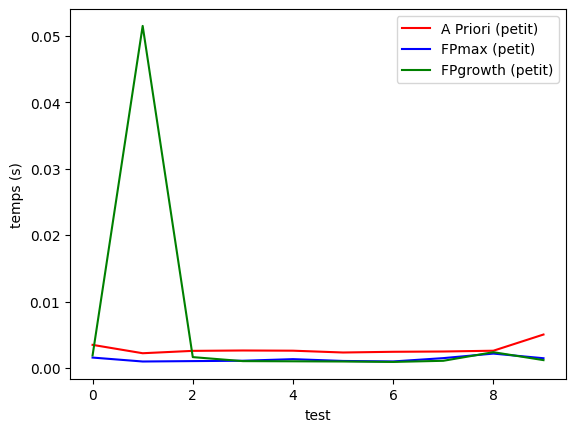

In [15]:
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
import timeit

NBR_IT = 10

te = TransactionEncoder()
te_ary = te.fit(data_achat).transform(data_achat)
df = pd.DataFrame(te_ary, columns=te.columns_)

temps = [[], [], [], [], [], []]

algos = [apriori, fpmax, fpgrowth]

for it in range(NBR_IT):
    for i, algo in enumerate(algos):
        temps_debut = timeit.default_timer()
        FI = algo(df, min_support=0.1, use_colnames=True)
        temps[i].append(timeit.default_timer() - temps_debut)
        
#         temps_debut = timeit.default_timer()
#         FI = algo(df_grand, min_support=0.1, use_colnames=True)
#         temps[i+3].append(timeit.default_timer() - temps_debut)

plt.plot(temps[0], label='A Priori (petit)', color='red')
plt.plot(temps[1], label='FPmax (petit)', color='blue')
plt.plot(temps[2], label='FPgrowth (petit)', color='green')

# plt.plot(temps[3], label='A Priori (grand)', color='red', linestyle='--')
# plt.plot(temps[4], label='FPmax (grand)', color='blue', linestyle='--')
# plt.plot(temps[5], label='FPgrowth (grans)', color='green', linestyle='--')

plt.xlabel('test')
plt.ylabel('temps (s)')
plt.legend()
plt.show()

**TODO: Analyser les résultats** 

- Que remarquez-vous ?
- Pourquoi la méthode APriori prend-t-elle plus de temps ?

**Réponse**

- ...
- ...

#### II.1.2. Effet du support minimal

Nous voulons tester l'effet du support minimal sur la création des itemsets fréquents.
Pour ce faire, nous allons utiliser FPgrowth avec des valeurs différentes de ce paramètre.


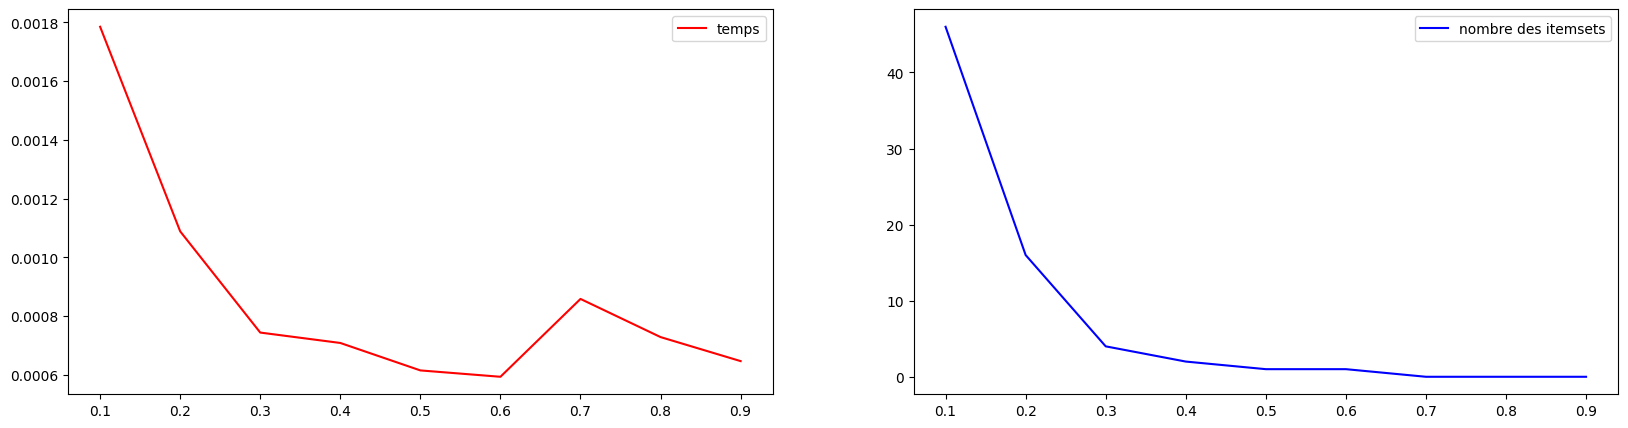

In [16]:
min_supports = np.arange(0.1, 1, 0.1)

temps_sm = []
itemsets_nbr = []

for min_support in min_supports:
    temps_debut = timeit.default_timer()
    FI = fpgrowth(df, min_support=min_support, use_colnames=True)
    temps_sm.append(timeit.default_timer() - temps_debut)
    
    itemsets_nbr.append(FI.shape[0])

    
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot(min_supports, temps_sm, label='temps', color='red')
axs[0].legend()
axs[1].plot(min_supports, itemsets_nbr, label='nombre des itemsets', color='blue')
axs[1].legend()
plt.show()


**TODO: Analyser les résultats** 

- Que remarquez-vous ?
- Justifier.

**Réponse**

- ...
- ...

### II.2. Génération des règles d'association

Ici, nous voulons tester l'effet de quelques paramètres sur la génération des règles d'association.
Nous allons utiliser les mêmes itemsets fréquents.


In [17]:
FI_01 = fpgrowth(df, min_support=0.1, use_colnames=True)

FI_01.tail()

,support,itemsets
41,0.1,"(jus, fromage, gateau)"
42,0.1,"(jus, qahwa, fromage, gateau)"
43,0.2,"(sakkar, qahwa)"
44,0.2,"(khobz, sakkar)"
45,0.1,"(khobz, sakkar, qahwa)"


In [18]:
FI_02 = fpgrowth(df, min_support=0.2, use_colnames=True)

FI_02.tail()

,support,itemsets
11,0.2,"(jus, qahwa)"
12,0.2,"(khobz, tai)"
13,0.2,"(tai, chocolat)"
14,0.2,"(sakkar, qahwa)"
15,0.2,"(khobz, sakkar)"


#### II.2.1. Métrique de sélection des règles

Ici, nous voulons tester l'effet du métrique utilisé pour générer les règles d'association : 

- Confiance
- Lift

In [19]:
from mlxtend.frequent_patterns import association_rules

association_rules(FI_02, metric='confidence', min_threshold=0.6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(7lib),(khobz),0.25,0.65,0.2,0.800000,1.230769,0.0375,1.75,0.250000
1,(jus),(qahwa),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.80,0.571429
2,(chocolat),(tai),0.25,0.35,0.2,0.800000,2.285714,0.1125,3.25,0.750000
3,(sakkar),(qahwa),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.80,0.571429
4,(sakkar),(khobz),0.30,0.65,0.2,0.666667,1.025641,0.0050,1.05,0.035714


In [20]:
association_rules(FI_02, metric='lift', min_threshold=1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(khobz),(7lib),0.65,0.25,0.2,0.307692,1.230769,0.0375,1.083333,0.535714
1,(7lib),(khobz),0.25,0.65,0.2,0.800000,1.230769,0.0375,1.750000,0.250000
2,(jus),(qahwa),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.800000,0.571429
3,(qahwa),(jus),0.40,0.30,0.2,0.500000,1.666667,0.0800,1.400000,0.666667
4,(tai),(chocolat),0.35,0.25,0.2,0.571429,2.285714,0.1125,1.750000,0.865385
5,(chocolat),(tai),0.25,0.35,0.2,0.800000,2.285714,0.1125,3.250000,0.750000
6,(sakkar),(qahwa),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.800000,0.571429
7,(qahwa),(sakkar),0.40,0.30,0.2,0.500000,1.666667,0.0800,1.400000,0.666667


**TODO: Analyser les résultats** 

- Est-ce que le résultat d'un métrique est inclus dans l'autre ? Pourquoi ?
- Pourquoi il y a des règles qui ont un grand lift pourtant ils ont une petite confiance (antécédent, conséquence) ?

**Réponse**

- ...
- ...

#### II.2.2. Seuil minimal

Ici, nous voulons tester l'effet du seuil minimal. 
Nous allons utiliser la confiance comme métrique.
Donc, nous changeons la confiance minimale et calculons les propriétés:
- Temps de création des règles ;
- Nombre des règles générées ;
- Longueur maximale de l'antécédent.

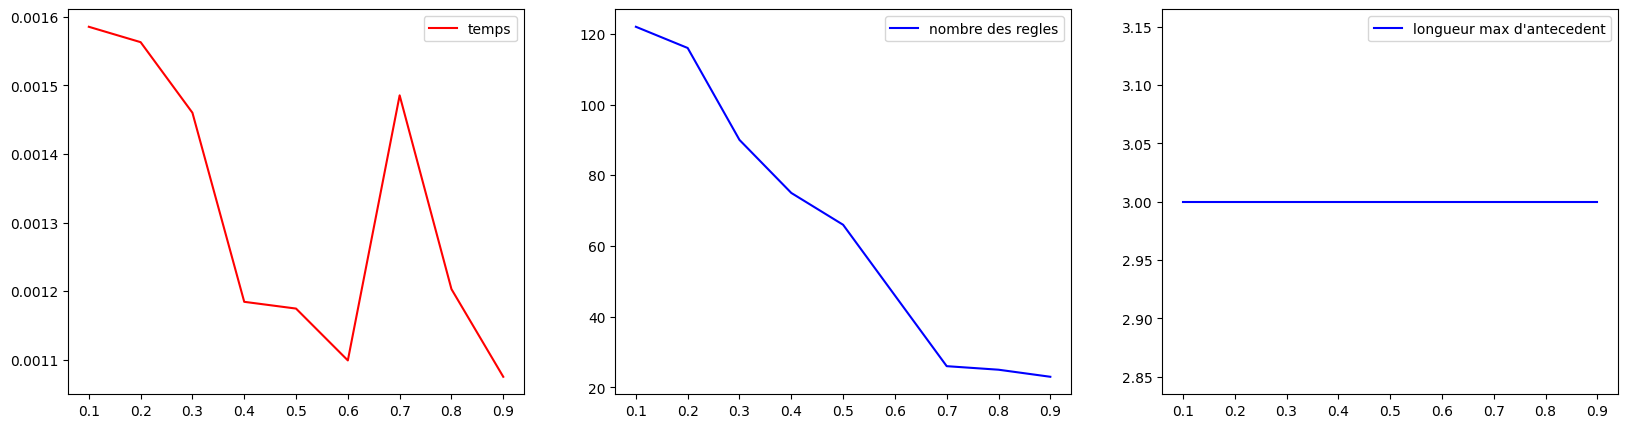

In [21]:
min_confiances = np.arange(0.1, 1, 0.1)

temps_regles = []
nbr_regles = []
antecedent_max_nbrs = []

for min_confiance in min_confiances:
    temps_debut = timeit.default_timer()
    regles = association_rules(FI_01, metric='confidence', min_threshold=min_confiance)
    temps_regles.append(timeit.default_timer() - temps_debut)
    
    nbr_regles.append(regles.shape[0])
    
    antecedent_nbrs = regles['antecedents'].apply(lambda x: len(x))
    antecedent_max_nbrs.append(antecedent_nbrs.max())

    
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].plot(min_confiances, temps_regles, label='temps', color='red')
axs[0].legend()
axs[1].plot(min_confiances, nbr_regles, label='nombre des regles', color='blue')
axs[1].legend()
axs[2].plot(min_confiances, antecedent_max_nbrs, label='longueur max d\'antecedent', color='blue')
axs[2].legend()
plt.show()

**TODO: Analyser les résultats** 

- Que remarquez-vous ? en déduisant si le nombre min affecte un des trois propriétés.

**Réponse**

- ...